C:\Users\rcc_0\AppData\Local\Temp\ipykernel_23104\2169723537.py:103: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


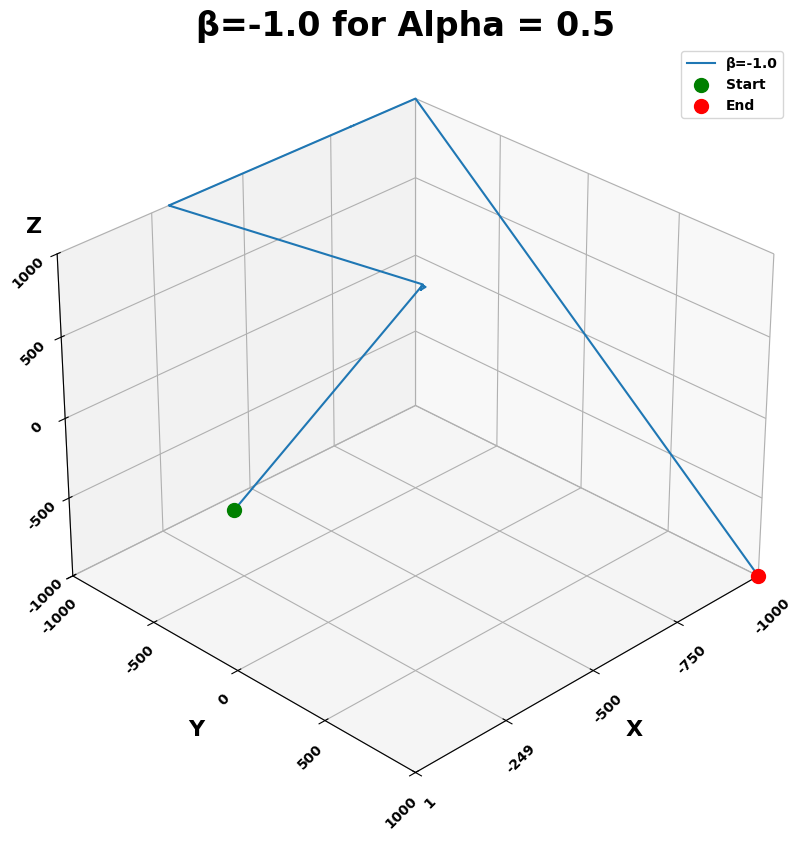

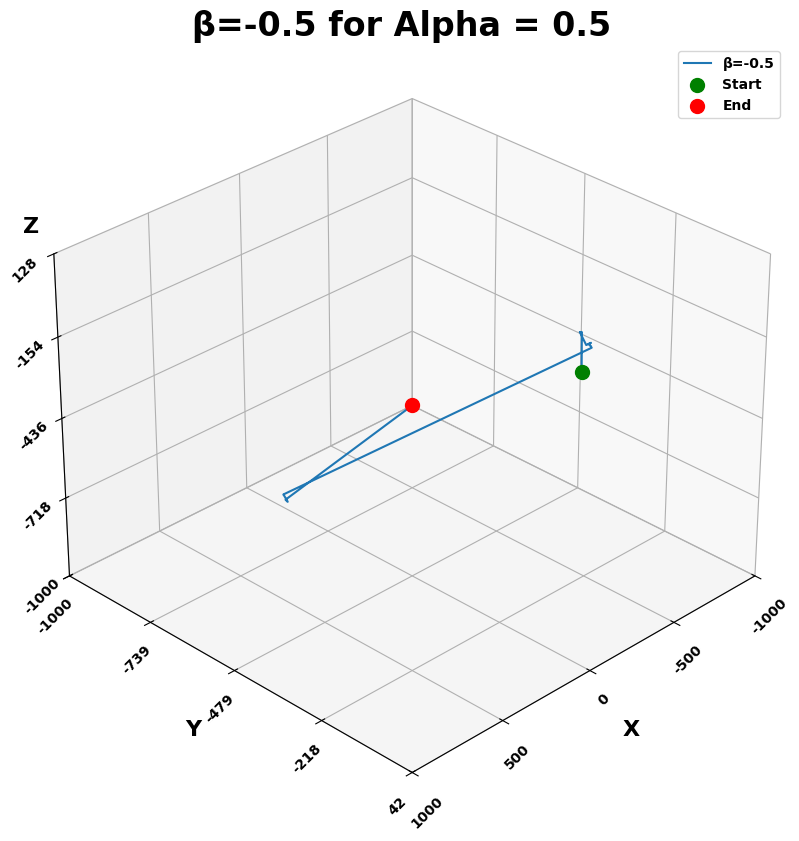

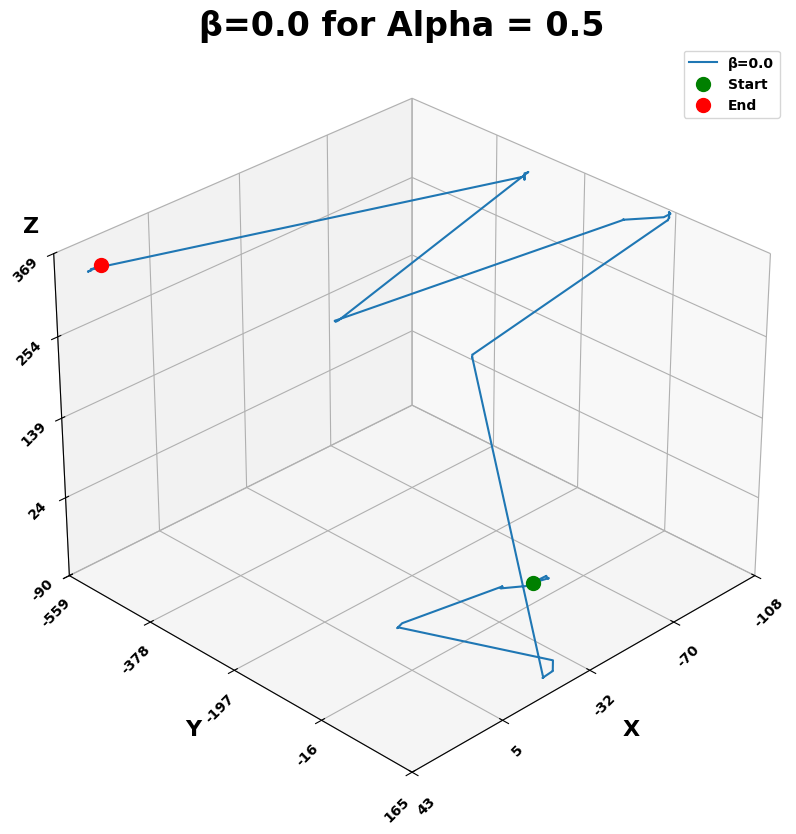

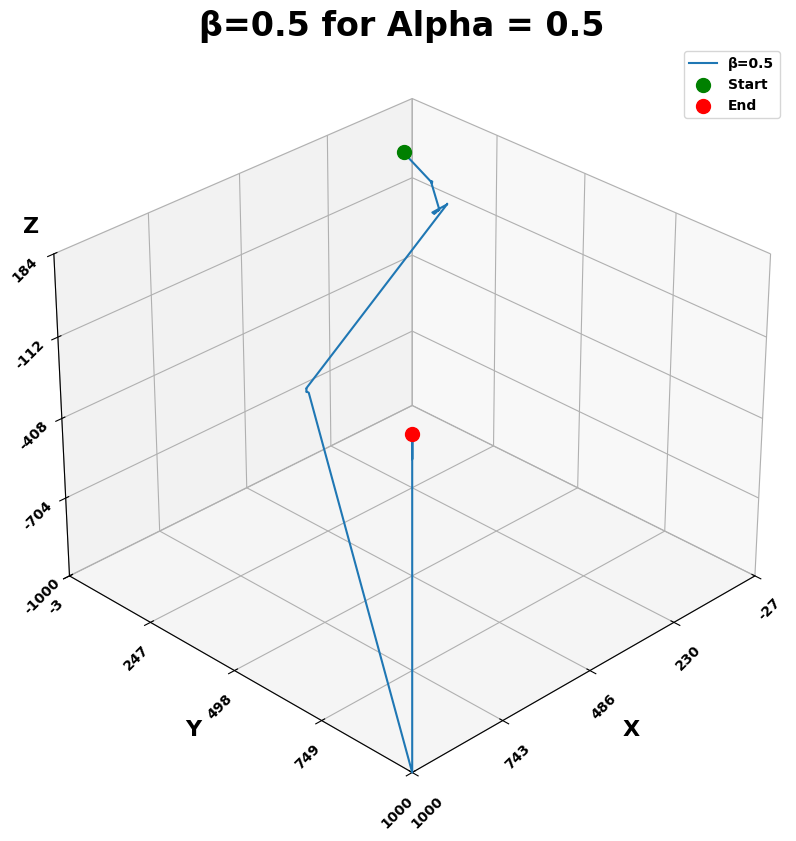

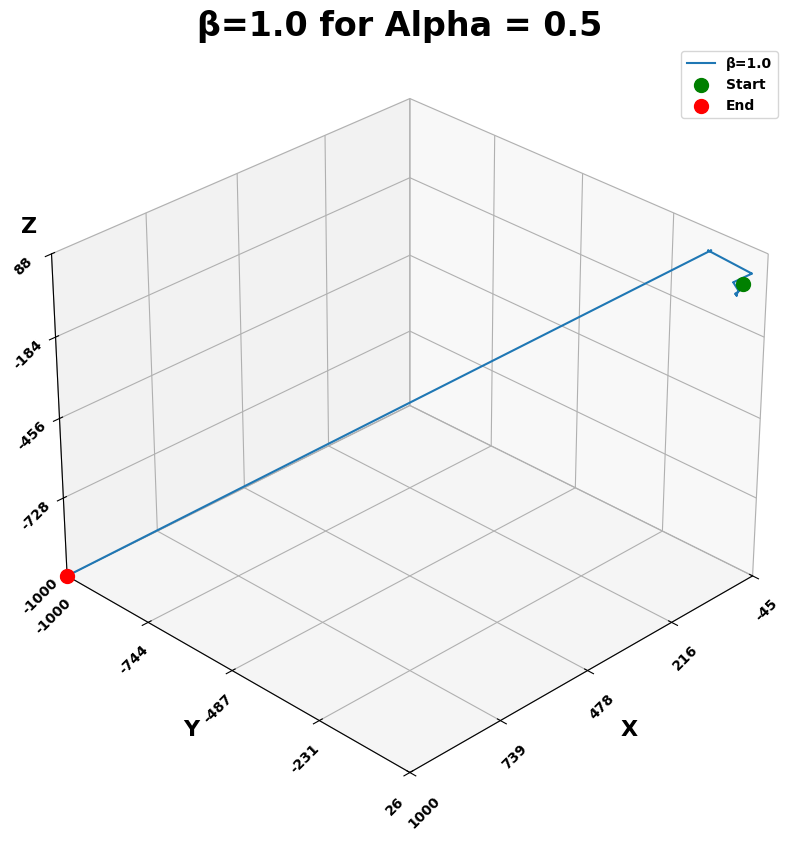

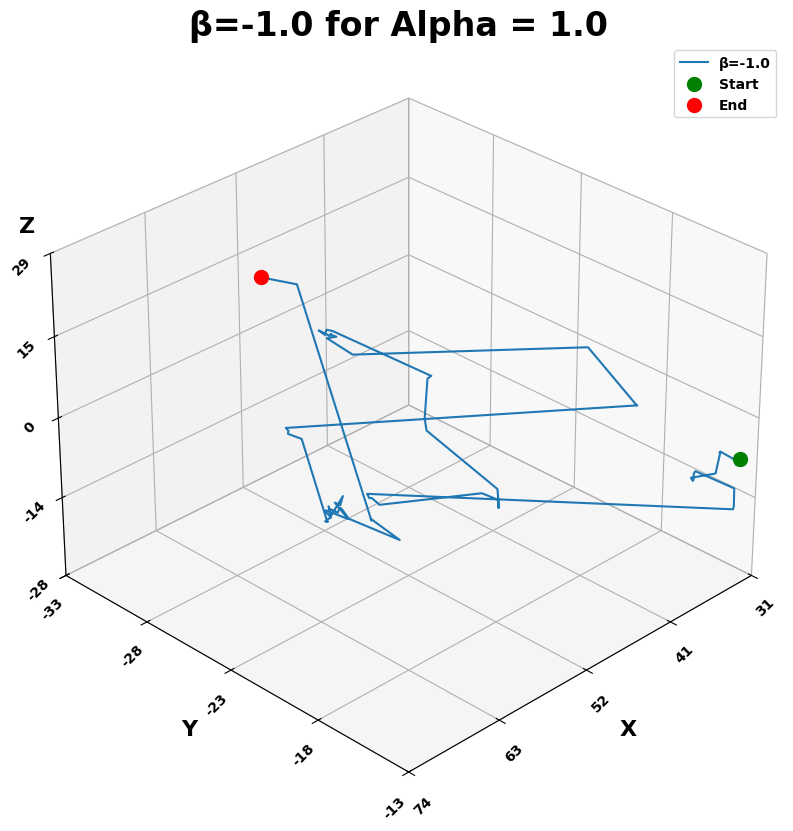

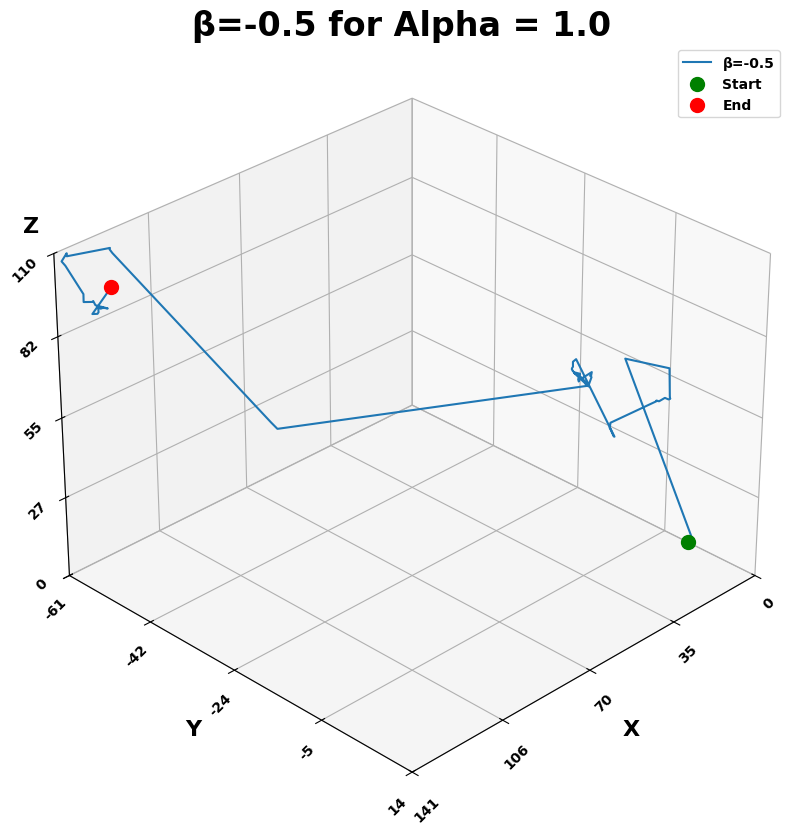

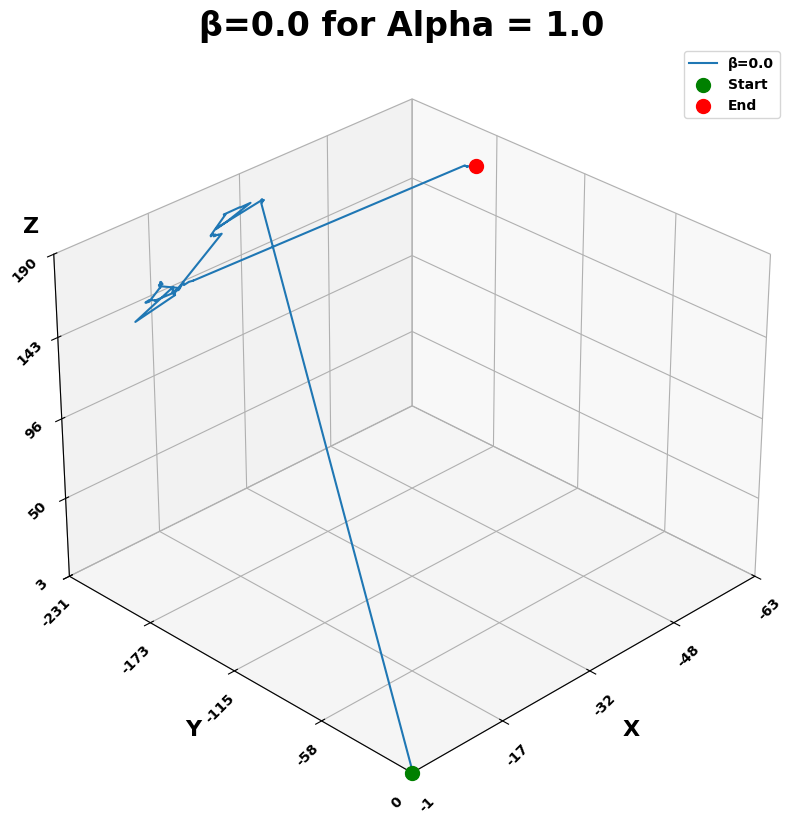

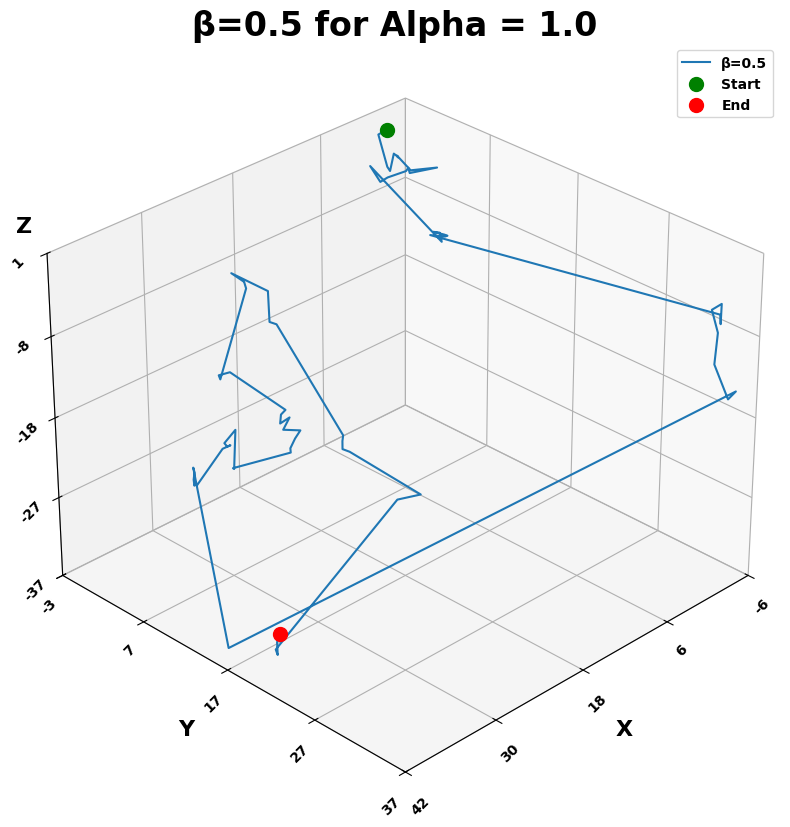

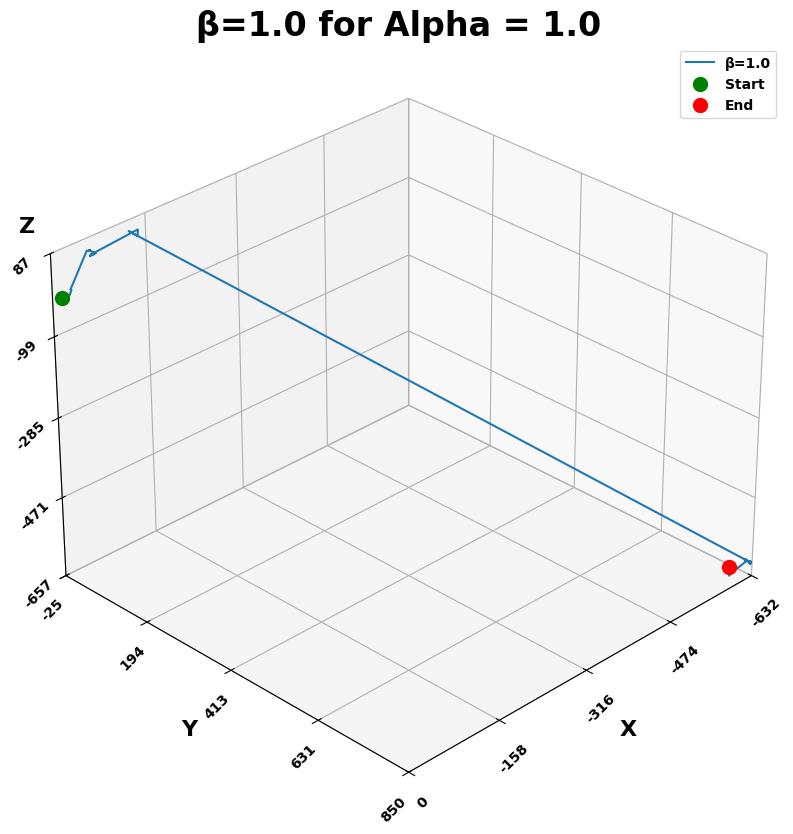

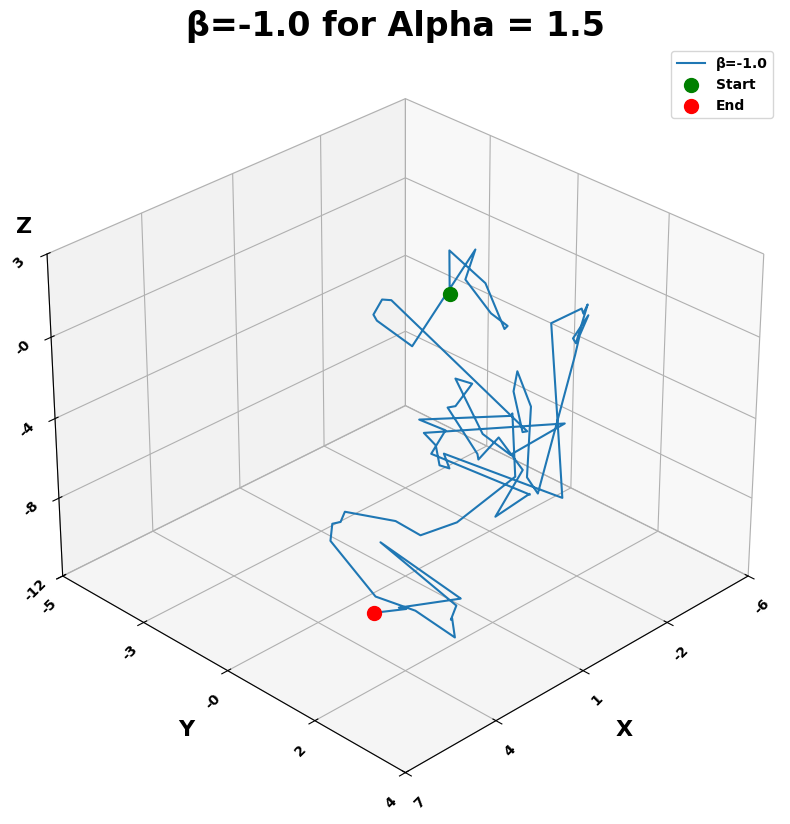

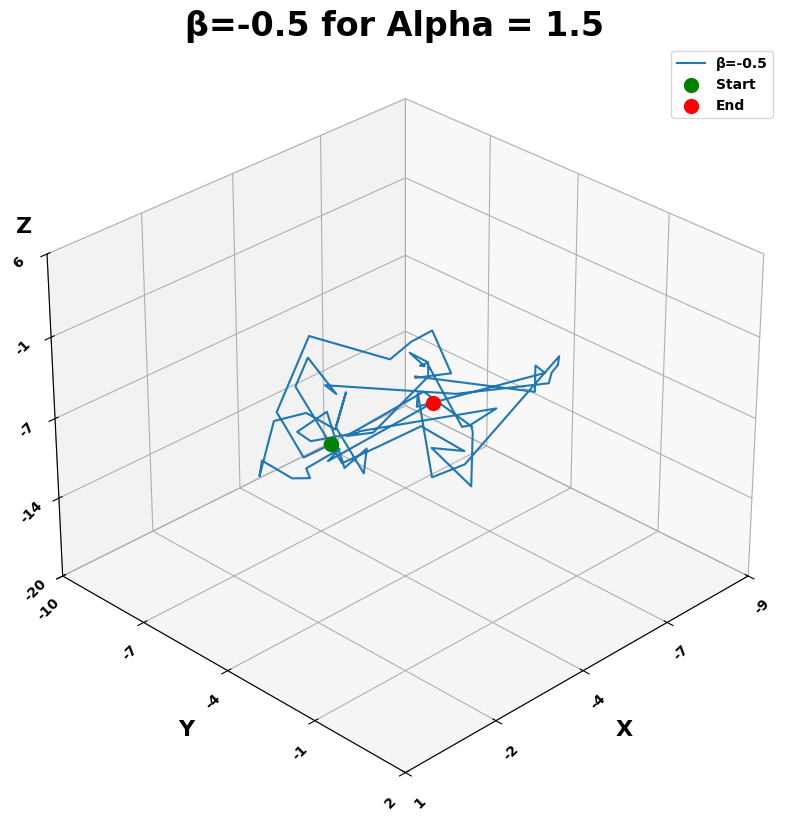

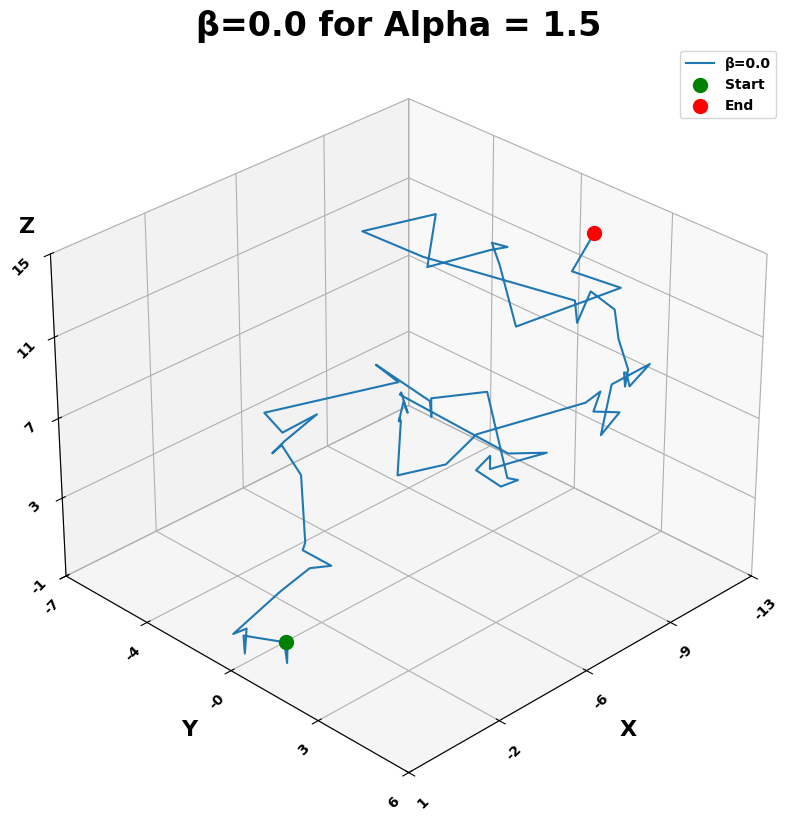

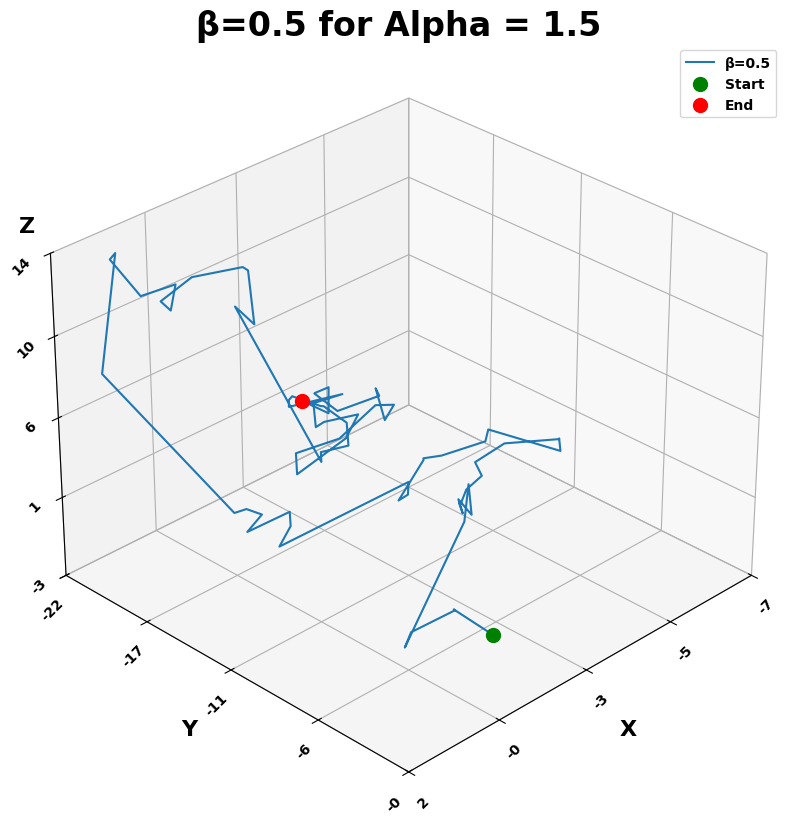

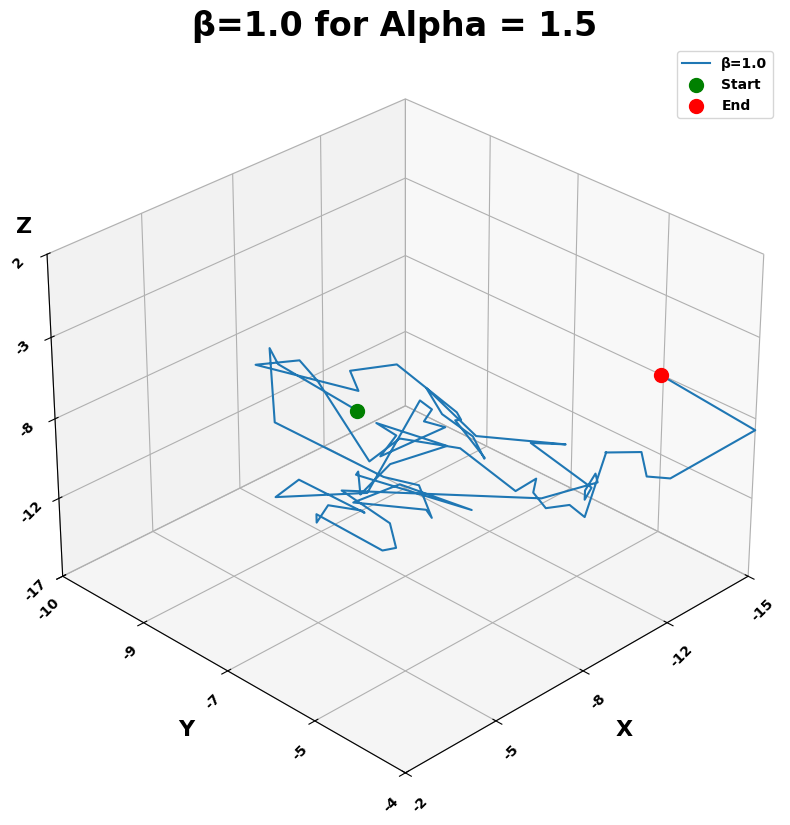

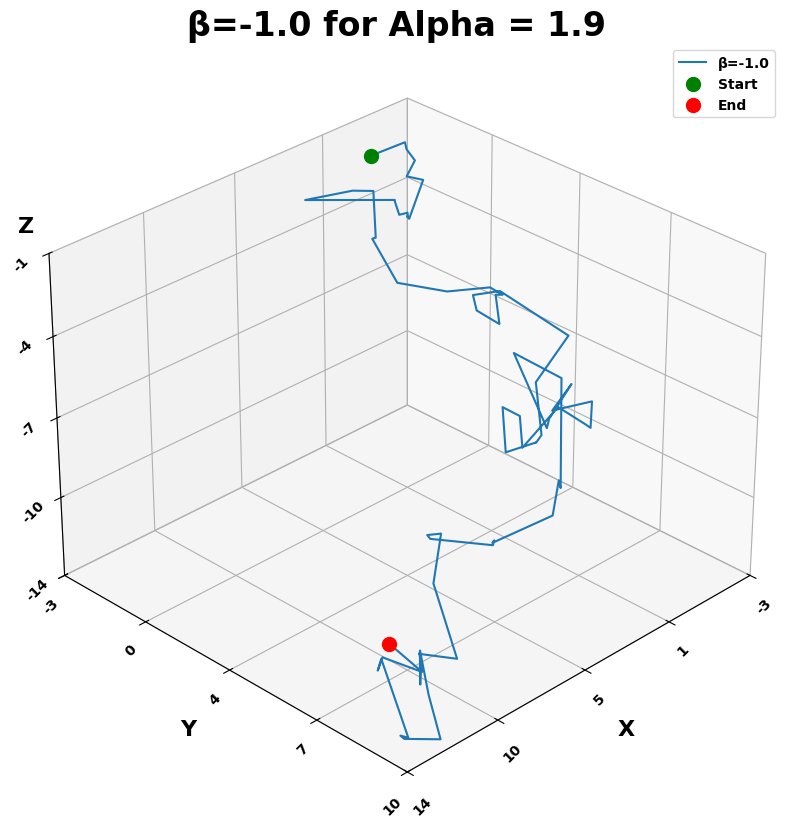

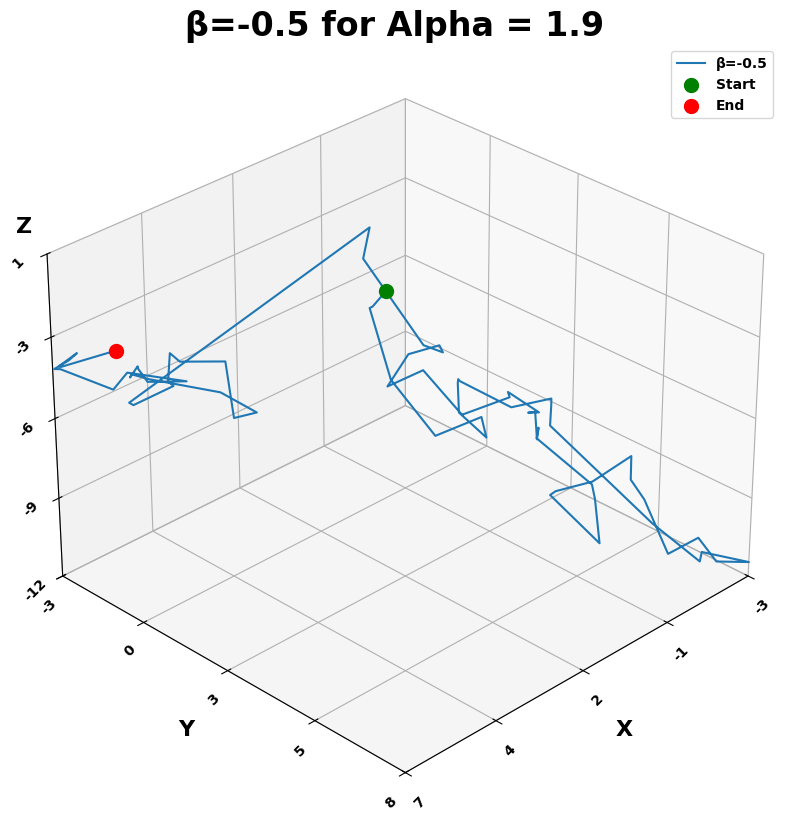

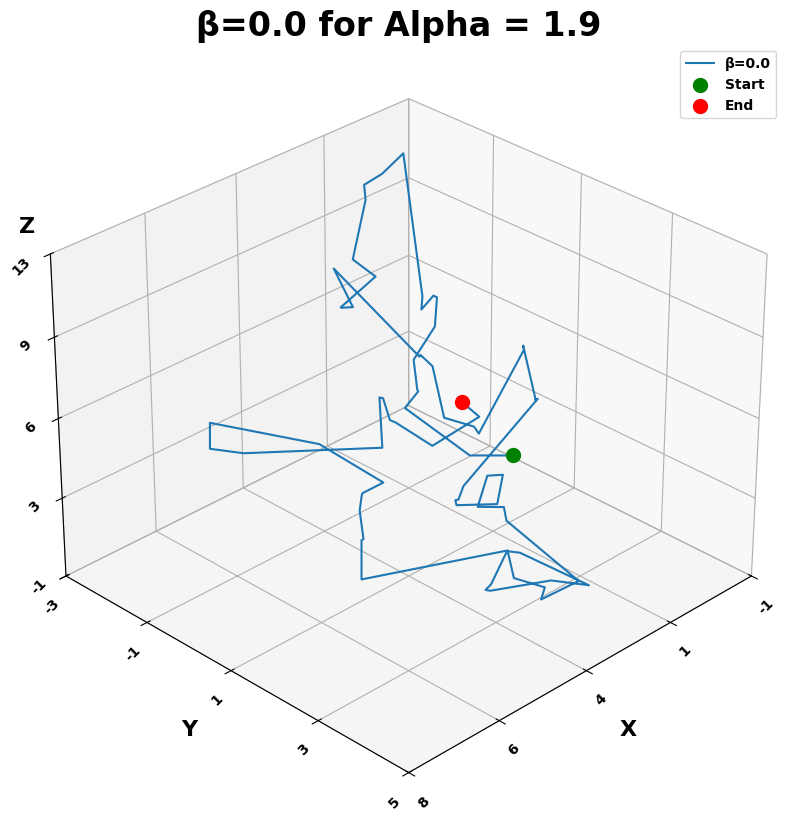

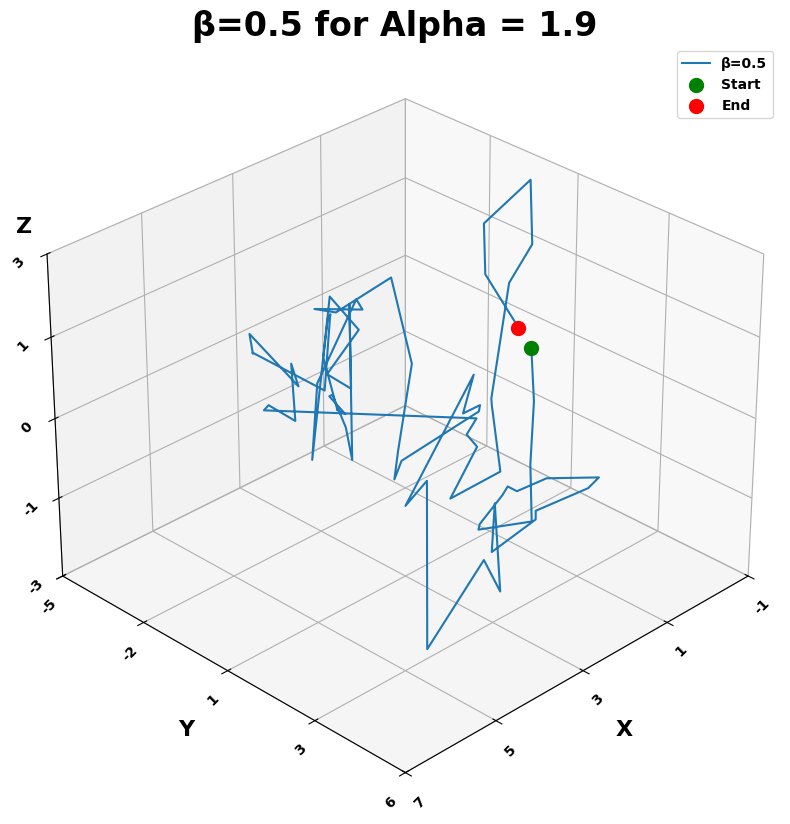

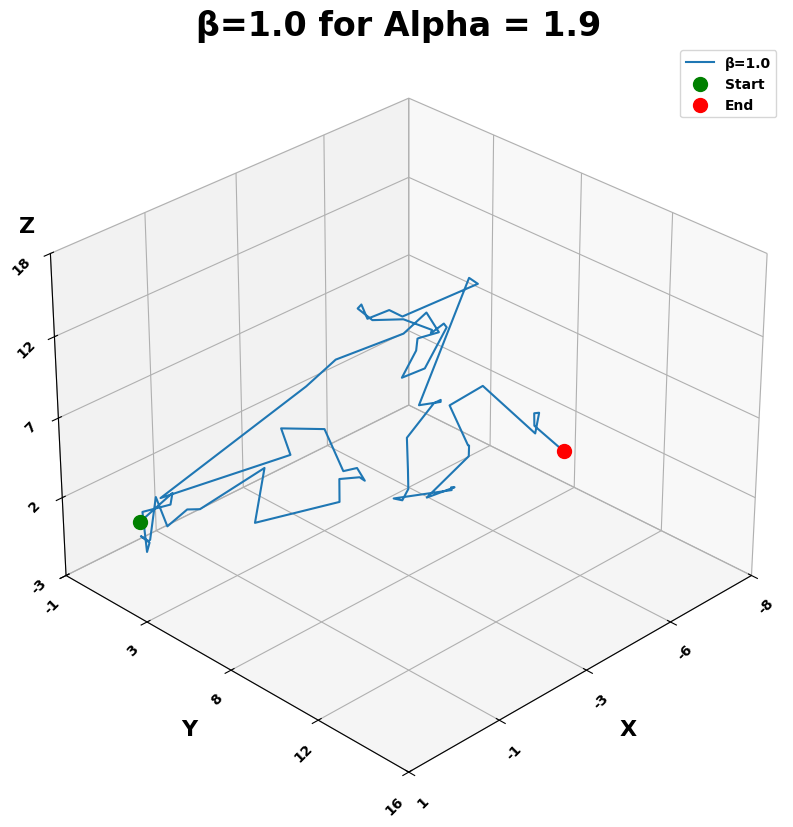

Average Distance Table (rounded to 3 decimal places):
Alpha       0.5      1.0      1.5     1.9
Beta                                     
-1.0   2906.182  314.347  122.173  83.543
-0.5   3234.055  605.700  101.776  87.874
 0.0   2918.192  324.543  161.494  84.535
 0.5   2999.595  388.524  110.479  88.860
 1.0   3166.573  864.734  161.478  91.249


In [31]:
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter

# Generates a random angle for the next step in 3D
def generate_3d_direction():
    theta = np.random.uniform(0, np.pi)  # Polar angle [0, π]
    phi = np.random.uniform(0, 2 * np.pi)  # Azimuthal angle [0, 2π]
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x, y, z

# Simulate a single Levy flight
def simulate_levy_flight(alpha, beta, steps=75):
    positions = np.zeros((steps, 3))  # Track x, y, z positions
    current_pos = np.array([0.0, 0.0, 0.0])  # Start at origin
  
    for i in range(steps):
        # Generate step length from Levy stable distribution with positive scale
        step_length = scipy.stats.levy_stable.rvs(alpha, beta, loc=0, scale=1.0, size=1)[0]
        # Generate 3D direction
        direction = np.array(generate_3d_direction())
        # Normalize direction and scale by step length
        direction = direction / np.linalg.norm(direction) * step_length
        # Update position
        current_pos += direction
        positions[i] = current_pos
  
    # Cap extreme values
    positions = np.clip(positions, -1000, 1000)
    # Calculate total distance traveled
    total_distance = np.sum(np.linalg.norm(positions[1:] - positions[:-1], axis=1))
    return positions, total_distance

# Parameters to vary
alphas = [0.5, 1.0, 1.5, 1.9]  # Alpha values (removed 0.1)
betas = [-1.0, -0.5, 0.0, 0.5, 1.0]  # Beta values
flights_per_combo = 100 // (len(alphas) * len(betas))  # Distribute 100 flights

# Store results for plotting
all_positions = []
all_distances = []
labels = []

for alpha in alphas:
    for beta in betas:
        for _ in range(flights_per_combo):
            positions, distance = simulate_levy_flight(alpha, beta)
            all_positions.append(positions)
            all_distances.append(distance)
            labels.append(f'α={alpha}, β={beta}')

# Group distances by parameter combination for averaging
distance_groups = {}
for i, label in enumerate(labels):
    if label not in distance_groups:
        distance_groups[label] = []
    distance_groups[label].append(all_distances[i])

# Compute average distances globally
avg_distances = {label: np.mean(dists) for label, dists in distance_groups.items()}

# Create individual figures for each beta per alpha
for alpha in alphas:
    for idx, beta in enumerate(betas):
        fig = plt.figure(figsize=(10, 10))  # Individual figure for each plot
        ax = fig.add_subplot(111, projection='3d')
        label = f'α={alpha}, β={beta}'
        combo_positions = [pos for i, pos in enumerate(all_positions) if labels[i] == label]
        if combo_positions:
            sample_path = combo_positions[0]
            x_min, x_max = np.clip([np.min(sample_path[:, 0]), np.max(sample_path[:, 0])], -1000, 1000)
            y_min, y_max = np.clip([np.min(sample_path[:, 1]), np.max(sample_path[:, 1])], -1000, 1000)
            z_min, z_max = np.clip([np.min(sample_path[:, 2]), np.max(sample_path[:, 2])], -1000, 1000)
            ax.plot(sample_path[:, 0], sample_path[:, 1], sample_path[:, 2], label=f'β={beta}')
            ax.scatter(sample_path[0, 0], sample_path[0, 1], sample_path[0, 2], color='green', label='Start', s=100)
            ax.scatter(sample_path[-1, 0], sample_path[-1, 1], sample_path[-1, 2], color='red', label='End', s=100)
            ax.set_title(f'β={beta} for Alpha = {alpha}', fontsize=24, fontweight='bold')
            ax.set_xlabel('X', labelpad=12, fontsize=16, fontweight='bold')
            ax.set_ylabel('Y', labelpad=12, fontsize=16, fontweight='bold')
            ax.set_zlabel('')  # Disable default Z-label
            ax.text(x_max + ((x_max-x_min)/24), y_min - ((y_max-y_min)/24), z_max + ((z_max-z_min)/16), 'Z', fontsize=16, fontweight='bold', zorder=10)  # Place Z at data coordinates
            ax.set_xlim([x_min, x_max])
            ax.set_ylim([y_min, y_max])
            ax.set_zlim([z_min, z_max])
            ax.set_xticks(np.linspace(x_min, x_max, 5))
            ax.set_yticks(np.linspace(y_min, y_max, 5))
            ax.set_zticks(np.linspace(z_min, z_max, 5))
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            for label in ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels():
                label.set_fontweight('bold')
                label.set_fontsize(10)
                label.set_rotation(45)
            ax.legend(fontsize=16, prop={'weight': 'bold'})
            ax.view_init(elev=30, azim=45)
        # fig.subplots_adjust(top=0.9, left=0.05, right=0.95, bottom=0.1) 
        plt.tight_layout()
        plt.show()

# Create table for average distances with 3 decimal place precision
import pandas as pd
table_data = {alpha: [] for alpha in alphas}
for alpha in alphas:
    for beta in betas:
        label = f'α={alpha}, β={beta}'
        avg_dist = avg_distances.get(label, 0)
        table_data[alpha].append(round(avg_dist, 3))

df = pd.DataFrame(table_data, index=betas)
df.index.name = 'Beta'
df.columns.name = 'Alpha'

print("Average Distance Table (rounded to 3 decimal places):")
print(df)